# Analysis of thermal effects

In [ ]:
%load_ext autoreload
%autoreload 2

### Imports

In [ ]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main'  # Analysis type
mouseline = 'line3'
layer = None  # cortical layer
slack_notify = False

### Load data

In [4]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = [f for f in os.listdir(datadir) if f.endswith('.h5')]

# Load data from each file into a dictionary
dFF, info_table = {}, {}
for fname in datafiles:
    dataset_ID = os.path.splitext(fname)[0]
    dFF[dataset_ID], info_table[dataset_ID] = load_rowavg_dataset(os.path.join(datadir, fname))

# Assemble into multi-indexed pandas Series
logger.info(f'assembling {len(dFF)} datasets into single multi-indexed series')
dFF = pd.concat(dFF, axis=0, names=[Label.DATASET])

# Assemble info table into single DataFrame
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET])
info_table = add_intensity_to_table(info_table)
info_table

 2025/07/01 16:02:17: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/main/line3
 2025/07/01 16:02:17: loading row-average dFF data from 20191107_mouse1_region1.h5
 2025/07/01 16:02:17: loading experiment info table...
 2025/07/01 16:02:17: loading row-average dFF data from 20191113_mouse9_region2.h5
 2025/07/01 16:02:17: loading experiment info table...
 2025/07/01 16:02:17: loading row-average dFF data from 20191108_mouse6_region2.h5
 2025/07/01 16:02:17: loading experiment info table...
 2025/07/01 16:02:17: loading row-average dFF data from 20200313_mouse14_region1.h5
 2025/07/01 16:02:17: loading experiment info table...
 2025/07/01 16:02:17: loading row-average dFF data from 20191024_mouse5_region1.h5
 2025/07/01 16:02:17: loading experiment info table...
 2025/07/01 16:02:17: loading row-average dFF data from 20190829_mouse10_region1.h5
 2025/07/01 16:02:17: loading experiment info table...
 2025/07/01 16:02:17: loading row-average dFF data from 20190704_mouse3_

line  trial_length  PRF (Hz)  duration (s)  \
dataset                 run                                                
20191107_mouse1_region1 0    line3           100     100.0           0.2   
                        1    line3           100     100.0           0.2   
                        2    line3           100     100.0           0.2   
                        3    line3           100     100.0           0.2   
                        4    line3           100     100.0           0.2   
...                            ...           ...       ...           ...   
20191108_mouse6_region1 10   line3           100     100.0           0.2   
                        11   line3           100     100.0           0.2   
                        12   line3           100     100.0           0.2   
                        13   line3           100     100.0           0.2   
                        14   line3           100     100.0           0.2   

                              fps  P (MPa)  DC (%)  run ID  \
dataset                 run                                  
20191107_mouse1_region1 0    3.56     0.80    50.0     713   
                        1    3.56     0.80    40.0     714   
                        2    3.56     0.80    30.0     715   
                        3    3.56     0.80    20.0     716   
                        4    3.56     0.80    10.0     717   
...                           ...      ...     ...     ...   
20191108_mouse6_region1 10   3.56     0.40    50.0     753   
                        11   3.56     0.20    50.0     754   
                        12   3.56     0.10    50.0     755   
                        13   3.56     0.05    50.0     756   
                        14   3.56     0.00    50.0     757   

                                                                          code  \
dataset                 run                                                      
20191107_mouse1_region1 0    line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-713   
                        1    line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-714   
                        2    line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-715   
                        3    line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-716   
                        4    line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-717   
...                                                                        ...   
20191108_mouse6_region1 10   line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753   
                        11   line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754   
                        12   line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755   
                        13   line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC...   
                        14   line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757   

                             I_SPPA (W/cm2)  I_SPTA (W/cm2)  
dataset                 run                                  
20191107_mouse1_region1 0         19.784475        9.892238  
                        1         19.784475        7.913790  
                        2         19.784475        5.935343  
                        3         19.784475        3.956895  
                        4         19.784475        1.978448  
...                                     ...             ...  
20191108_mouse6_region1 10         4.946119        2.473059  
                        11         1.236530        0.618265  
                        12         0.309132        0.154566  
                        13         0.077283        0.038642  
                        14         0.000000        0.000000  

[360 rows x 11 columns]

### Average across trials, and add experiment info table

In [5]:
# Average across trials
logger.info('averaging across trials')
trialagg_dFF = dFF.groupby([Label.DATASET, Label.RUN, Label.TIME]).mean()

# Add info table to trial-aggregated dFF
trialagg_dFF = free_expand_and_add(info_table, trialagg_dFF.to_frame())
trialagg_dFF

 2025/07/01 16:02:48: averaging across trials
 2025/07/01 16:03:41: expanding (25 datasets x 16 runs) input dataframe to match (25 datasets x 16 runs x 102397 time (s)s) reference dataframe


ΔF/F0   line  trial_length  \
dataset                  run time (s)                                    
20190704_mouse2_region1  0   -2.804532  -0.040349  line3           100   
                             -2.803436  -0.039015  line3           100   
                             -2.802341  -0.040806  line3           100   
                             -2.801245  -0.045283  line3           100   
                             -2.800150  -0.042168  line3           100   
...                                           ...    ...           ...   
20200612_mouse13_region1 14   25.232159  0.035210  line3           100   
                              25.233255  0.035595  line3           100   
                              25.234350  0.035847  line3           100   
                              25.235445  0.036461  line3           100   
                              25.236541  0.035447  line3           100   

                                         PRF (Hz)  duration (s)   fps  \
dataset                  run time (s)                                   
20190704_mouse2_region1  0   -2.804532      100.0           0.2  3.56   
                             -2.803436      100.0           0.2  3.56   
                             -2.802341      100.0           0.2  3.56   
                             -2.801245      100.0           0.2  3.56   
                             -2.800150      100.0           0.2  3.56   
...                                           ...           ...   ...   
20200612_mouse13_region1 14   25.232159     100.0           0.2  3.56   
                              25.233255     100.0           0.2  3.56   
                              25.234350     100.0           0.2  3.56   
                              25.235445     100.0           0.2  3.56   
                              25.236541     100.0           0.2  3.56   

                                         P (MPa)  DC (%)  run ID  \
dataset                  run time (s)                              
20190704_mouse2_region1  0   -2.804532       0.8    40.0     280   
                             -2.803436       0.8    40.0     280   
                             -2.802341       0.8    40.0     280   
                             -2.801245       0.8    40.0     280   
                             -2.800150       0.8    40.0     280   
...                                          ...     ...     ...   
20200612_mouse13_region1 14   25.232159      0.0    50.0     135   
                              25.233255      0.0    50.0     135   
                              25.234350      0.0    50.0     135   
                              25.235445      0.0    50.0     135   
                              25.236541      0.0    50.0     135   

                                                                                      code  \
dataset                  run time (s)                                                        
20190704_mouse2_region1  0   -2.804532   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-280   
                             -2.803436   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-280   
                             -2.802341   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-280   
                             -2.801245   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-280   
                             -2.800150   line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-280   
...                                                                                    ...   
20200612_mouse13_region1 14   25.232159  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-135   
                              25.233255  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-135   
                              25.234350  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-135   
                              25.235445  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-135   
                              25.236541  line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-135   

                       

### Plot trial-aggregated dFF throughout stimulus, vs ISPTA

In [20]:
fps = get_singleton(info_table, Label.FPS)
lps = fps * 256
print(lps, 1/ lps)

911.36 0.0010972612359550563


In [26]:
np.round(trialagg_dFF.index.get_level_values(Label.TIME), 4).unique()

Index([-2.8045, -2.8034, -2.8023, -2.8012, -2.8001, -2.7991,  -2.798, -2.7969,
       -2.7958, -2.7947,
       ...
       25.2251, 25.2262, 25.2273, 25.2284, 25.2295, 25.2306, 25.2317, 25.2328,
       25.2339, 25.2349],
      dtype='float64', name='time (s)', length=88229)

In [ ]:
nrowpertrial = 256 * 100

25600

 2025/07/01 16:18:52: plotting trial-averaged averaged dFF


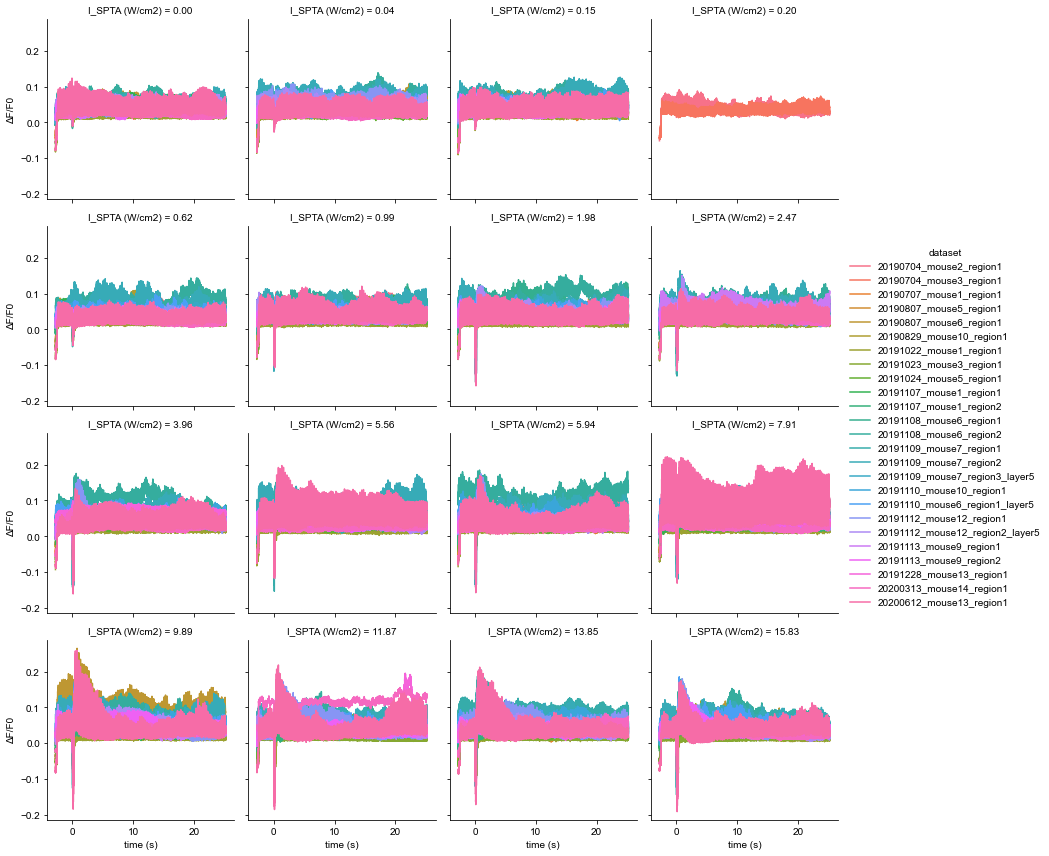

In [28]:
# Plot trial-averaged dFF across datasets, per ISPTA
tlims = (-0.02, 0.03)
logger.info('plotting trial-averaged averaged dFF')
g = sns.relplot(
    kind='line',
    data=trialagg_dFF.loc[pd.IndexSlice[:, :, :], :], #tlims[0]:tlims[1]], :],
    x=Label.TIME,
    y=Label.DFF,
    hue=Label.DATASET,
    col=Label.ISPTA,
    col_wrap=4,
    height=3,
    errorbar=None,
)
g.set_titles(col_template="{col_var} = {col_name:.2f}")
# for ax in g.axes:
#     ax.axvspan(0, 0.2, fc='silver', alpha=0.5, label='stimulus')
# sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, .5))